In [2]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
#our processing code
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *

# used for motors
import asyncio
import math
import moteus

#used for GUI
%matplotlib notebook

#find transform
import transforms3d as t3d
import time

# collect MSE from all the Trials
E_list = []

## Motor Functions

### zero on the center, user enter the startng postion in degree

In [3]:
async def setup(stop_torque=.299,v=1,torque=0.3,test=False):
    """
    This function setup the motor to "zero":

    Args:
        stop_torque (float): the therhold torque that tells when the motor should stop.
        v (float): the verlocity for the motor to move in rad/s.
        torque (float): the maximum torque for the motor.

    Returns:
        float: the "zero" position in radians

    """
    i = 0
    print("begin setup")
    c = moteus.Controller()
    await c.set_stop()
    state = await c.set_position(position=math.nan, query=True)
    print("state info: ",state)
    print("Position:", state.values[moteus.Register.POSITION])
    print("Torque:", state.values[moteus.Register.TORQUE])
    print()
    await asyncio.sleep(0.02) # wait for the motor to change state
    while True:
        state = await c.set_position(position=math.nan, velocity = -v, maximum_torque= torque,query=True)
        #print("Position:", state.values[moteus.Register.POSITION])
        #print("Torque:", state.values[moteus.Register.TORQUE])
        #print()
        await asyncio.sleep(0.001) # wait for spped command to reach the motor
        toq = state.values[moteus.Register.TORQUE]
        if abs(toq) >= stop_torque:
            #print("Position:", state.values[moteus.Register.POSITION])
            #print("Torque:", state.values[moteus.Register.TORQUE])
            await c.set_stop()
            print("motor is ready")
            p = state.values[moteus.Register.POSITION]
            break
        if not test:
            i+=1
    if test:
        for x in range(700):
            await c.set_position(position=math.nan, velocity = v, maximum_torque= torque,query=True)
    print("Initial Starting Degree: ","{:.2f}".format(math.degrees(p)))
    return p

In [4]:
async def setup1(stop_torque=.299,v=0.2,torque=0.3,test=False):
    """
    This function setup the motor to "zero":

    Args:
        stop_torque (float): the therhold torque that tells when the motor should stop.
        v (float): the verlocity for the motor to move in rad/s.
        torque (float): the maximum torque for the motor.

    Returns:
        float: the "zero" position in radians

    """
    print("begin setup")
    c = moteus.Controller()
    await c.set_stop()
    state = await c.set_position(position=math.nan, query=True)
    print("state info: ",state)
    print("Position:", state.values[moteus.Register.POSITION])
    print("Torque:", state.values[moteus.Register.TORQUE])
    print()
    await asyncio.sleep(0.02) # wait for the motor to change state
    while True:
        state = await c.set_position(position=math.nan, velocity = -v, maximum_torque= torque,query=True)
        #print("Position:", state.values[moteus.Register.POSITION])
        #print("Torque:", state.values[moteus.Register.TORQUE])
        #print()
        await asyncio.sleep(0.001) # wait for spped command to reach the motor 
        if abs(state.values[moteus.Register.TORQUE]) > stop_torque:
            #print("Position:", state.values[moteus.Register.POSITION])
            #print("Torque:", state.values[moteus.Register.TORQUE])
            await c.set_stop()
            print("reach first limit")
            p1 = state.values[moteus.Register.POSITION]
            break
        state = await c.set_position(position=math.nan, velocity = v, maximum_torque= torque,query=True)
        await asyncio.sleep(0.001) # wait for spped command to reach the motor 
        if state.values[moteus.Register.TORQUE] > stop_torque:
            #print("Position:", state.values[moteus.Register.POSITION])
            #print("Torque:", state.values[moteus.Register.TORQUE])
            await c.set_stop()
            print("reach secound limit")
            p2 = state.values[moteus.Register.POSITION]
            break
        state = await c.set_position(position=(p1-p2)/2,query=True)
        await asyncio.sleep(0.001) # wait for spped command to reach the motor 
        p = state.values[moteus.Register.POSITION]
        await c.set_stop()
        print("motor is ready")
        print("Initial Starting Degree: ","{:.2f}".format(math.degrees(p)))
    return p

In [5]:
async def one_axis_test(intial_position,user_degree=0,stop_torque=.299,v=1,torque=0.3):
    """
    This function runs the motor farward and backward:

    Args:

    Returns:

    """
    p = intial_position
    p_list = []
    ud = math.radians(user_degree)/((2*math.pi))
    print("Begain Testing")
    c = moteus.Controller()
    for x in range(1000):
        state = await c.set_position(position=math.nan+p+ud, velocity = v, maximum_torque=torque, query=True)
        await asyncio.sleep(0.001)
        if state.values[moteus.Register.TORQUE] > stop_torque:
            print("stoped")
            p_list.append(state.values[moteus.Register.POSITION]*(2*math.pi))
            break
    await c.set_stop()
    print("Finish")
    return p_list

In [6]:
async def one_axis_test2(intial_position,user_degree=0,stop_torque=.299,v=1,torque=0.3):
    """
    This function runs the motor farward and backward:

    Args:

    Returns:

    """
    p = intial_position
    p_list = []
    ud = math.radians(user_degree)/((2*math.pi))
    c = moteus.Controller()
    print("car coming back")
    for x in range(1000):
        state = await c.set_position(position=math.nan-(p+ud), velocity = -v, maximum_torque=torque, query=True)
        await asyncio.sleep(0.001)
        if state.values[moteus.Register.TORQUE] > stop_torque:
            print("stoped")
            break
    await c.set_stop()
    print("Finish")
    return p_list

In [7]:
async def read_p(stop_torque=.299,v=0,torque=0):
    """
    This function runs the motor farward and backward:

    Args:

    Returns:

    """
    print("Begain Testing")
    c = moteus.Controller()
    await c.set_stop()
    state = await c.set_position(position=math.nan, velocity = v, maximum_torque=torque, query=True)
    await asyncio.sleep(0.001)
    p = state.values[moteus.Register.POSITION]
    await c.set_stop()
    print("Position:", p)
    print("Position in Degree: ","{:.2f}".format(math.degrees(p)))
    return p

In [8]:
async def rotational_test(intial_position,user_degree,stop_torque=.299,v=0.2,torque=0.3):
    """
    This function runs the motor to the user input degree:

    Args:

    Returns:

    """
    p = intial_position
    p_list = []
    u_r = math.radians(user_degree)
    print("user desired radians: ", u_r)
    u_r = u_r/(2*math.pi)
    print("Begain Testing")
    c = moteus.Controller()
    await c.set_stop()
    state = await c.set_position(position=p+u_r, query=True)
    await asyncio.sleep(0.001)
    p_list.append(state.values[moteus.Register.POSITION]*(2*math.pi))
    await c.set_stop()
    print("Finish")
    return p_list

## Setup the Motor

#### Run the code below to check the motor each Test

In [9]:
async def stopping_acc_test(n_loop):
    position_setpoint_list = []
    save_time = []
    for i in range(n_loop):
        position_setpoint_list.append(math.degrees((await setup(v=-1,test=True)*(2*math.pi))))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(position_setpoint_list)
    ax.set_title('Stopping Accuracy Test Plot')
    ax.set_ylabel('degree')
    plt.show()

Enter the number of loop5
begin setup
state info:  1/{MODE(0x000): 0, POSITION(0x001): 0.515716552734375, VELOCITY(0x002): 0.06745497137308121, TORQUE(0x003): 0.0, VOLTAGE(0x00d): 23.5, TEMPERATURE(0x00e): 21.0, FAULT(0x00f): 0}
Position: 0.515716552734375
Torque: 0.0

motor is ready
Initial Starting Degree:  3480.51
begin setup
state info:  1/{MODE(0x000): 0, POSITION(0x001): 59.16154479980469, VELOCITY(0x002): -0.7857628464698792, TORQUE(0x003): 0.0, VOLTAGE(0x00d): 23.5, TEMPERATURE(0x00e): 23.0, FAULT(0x00f): 0}
Position: 59.16154479980469
Torque: 0.0

motor is ready
Initial Starting Degree:  3480.19
begin setup
state info:  1/{MODE(0x000): 0, POSITION(0x001): 58.96659851074219, VELOCITY(0x002): -1.283939242362976, TORQUE(0x003): 0.0, VOLTAGE(0x00d): 23.5, TEMPERATURE(0x00e): 23.0, FAULT(0x00f): 0}
Position: 58.96659851074219
Torque: 0.0

motor is ready
Initial Starting Degree:  3480.89
begin setup
state info:  1/{MODE(0x000): 0, POSITION(0x001): 59.16102600097656, VELOCITY(0x002):

<IPython.core.display.Javascript object>


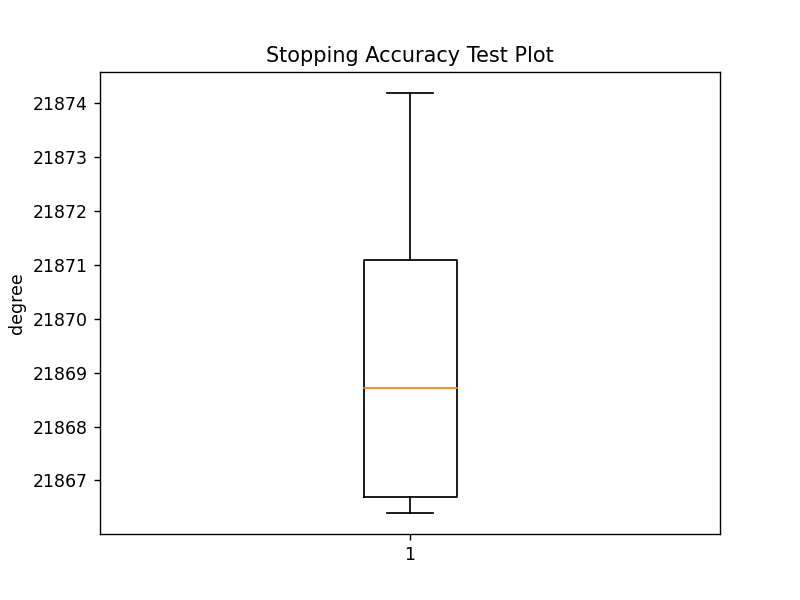

In [9]:
n = input('Enter the number of loop')
await stopping_acc_test(int(n))

## Let's Start the Test

### First, zero the motor and save the initial position(radian,shows in degree)

In [17]:
input('Press Enter to Start the Test')
ip = await setup(stop_torque=.1,v=1)
print("Initial Starting Radian: ", ip*(2*math.pi))

Press Enter to Start the Test
begin setup
state info:  1/{MODE(0x000): 0, POSITION(0x001): 36.381072998046875, VELOCITY(0x002): 0.010003713890910149, TORQUE(0x003): 0.0, VOLTAGE(0x00d): 23.5, TEMPERATURE(0x00e): 22.0, FAULT(0x00f): 0}
Position: 36.381072998046875
Torque: 0.0

motor is ready
Initial Starting Degree:  -11.99
Initial Starting Radian:  -1.3151009042142088


In [20]:
ip = await read_p()

Begain Testing


Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\moteus\aiostream.py", line 119, in _write_child
    _run_queue(self._write_queue)
  File "C:\ProgramData\Anaconda3\lib\site-packages\moteus\aiostream.py", line 37, in _run_queue
    item()
  File "C:\ProgramData\Anaconda3\lib\site-packages\moteus\aiostream.py", line 104, in do_write
    self.fd.write(write_data)
  File "C:\ProgramData\Anaconda3\lib\site-packages\serial\serialwin32.py", line 317, in write
    raise SerialException("WriteFile failed ({!r})".format(ctypes.WinError()))
serial.serialutil.SerialException: WriteFile failed (PermissionError(13, 'The device does not recognize the command.', None, 22))


CancelledError: 

### Run the CT scan for checking the postion error later.

### Once get the intial starting postion, run the testing function with the desired postion, and then run the CT scanner once motor moved.

In [11]:
data_p_list = []
data_degree_list = []
data_time_list = []

In [19]:
uds = int(input('Enter the desired degree (2000)'))
data_degree_list.append(uds)

Enter the desired degree (2000)2000


In [20]:
currcent_p_list = []
currcent_p_list.append(await one_axis_test(intial_position =ip,user_degree=uds))
data_p_list.append(currcent_p_list)
data_time_list.append(time.time())

Begain Testing
Finish


In [15]:
currcent_p_list = []
currcent_p_list.append(await one_axis_test2(intial_position =ip,user_degree=uds))
data_p_list.append(currcent_p_list)
data_time_list.append(time.time())

car coming back


CancelledError: 

### Plot the result

In [22]:
import pickle
with open('position.pkl', 'wb') as f:
    pickle.dump(data_p_list, f)
with open('degree.pkl', 'wb') as f:
    pickle.dump(data_degree_list, f)
with open('time.pkl', 'wb') as f:
    pickle.dump(data_time_list, f)

#### python -m moteus_gui.tview --devices=1

## Feltch the DICOM file from server

### Goto the website:  http://unicorn2.ucsd.edu:8080/dcm4chee-arc/ui2/#/study/patient

### Selected Series on the top tabs

### On the left hand side input: DIMITRI07041995 as the Patient ID

### In the middle section select Newest Frist in the Order by Tab

### In the middle section select DCM4CHEE in the Web App Service Tab and CLICK Sumbit

### Download the 1st row by clicking the 3 dots symbol and downolad it

### Once Downloaded, extract the DICOM file folder ONLY to the following folder: ./test_data

## Processing DICOM file

### Enter the DICOM folder name that contians the files

In [21]:
scan_file = './test_data/'
name = input('Enter the name of the DICOM folder: ')
scan_file = scan_file+name
print("New scan file name: ",scan_file)

Enter the name of the DICOM folder: 863148B2
New scan file name:  ./test_data/863148B2


### Pick target marker postion(1 or 2)

In [23]:
#choose target marker
name = input('Enter the targert marker postion, please enter 1 or 2: ')
if int(name) == 1:
    target_marker = 'marker1'
elif int(name) == 2:
    target_marker = 'marker2'
print("You have choose the target marker: ",target_marker)

Enter the targert marker postion, please enter 1 or 2: 1
You have choose the target marker:  marker1


### Convert DICOM files

In [24]:
#convert scan to mesh for finding markers via thresholding
# !!! comment the below code to change the way file is loaded !!!
#convert_scan_to_mesh(scan_file='./test_data/bb_marker3.pkl')
#convert_scan_to_mesh_mha(scan_file='./test_data/biopsy 2')
convert_scan_to_mesh_mha(scan_file)

spacing:  [0.62500392 0.878906   0.878906  ]
image_stack shape:  (256, 512, 512)


### Disaply DICOM file (Left and Right are the SAME)

origin: (-225.0, -225.0, -149.688)
size: (512, 512, 256)
spacing: (0.878906, 0.878906, 0.6250039215686274)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1

origin: (-225.0, -225.0, -149.688)
size: (512, 512, 256)
spacing: (0.878906, 0.878906, 0.6250039215686274)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1



<IPython.core.display.Javascript object>


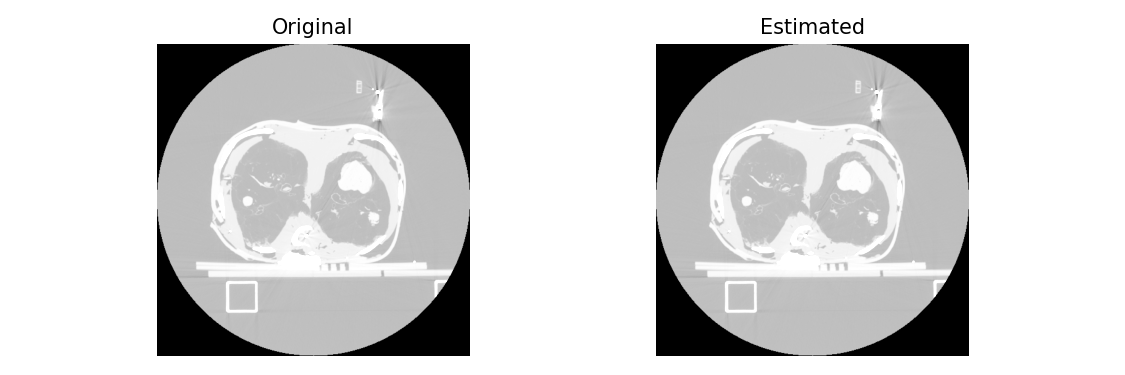

In [26]:
display_Dicom("temp_mesh.mha","temp_mesh.mha")

### Once the Imag above looks right, run the following code the find the neede error and transform

In [27]:
#find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
marker, marker_centroid_coordinates, pcd_selected, mesh, coordinate_frame, good_centroid_clusters = find_candidate_centroids(target_marker = target_marker)

#display candidate fiducials
o3d.visualization.draw_geometries([pcd_selected, mesh])
print('marker centroid coordinates from design: {}'.format(marker))
print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

#find best transform and marker from candidate fiducials
final_R, final_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 49


  4%|███▍                                                                               | 2/49 [00:00<00:02, 19.72it/s]C:\Users\derek\ECE\CT Research\ct-fiducial-tracking-main\ct_tracking_library\ct_tracking_functions.py:376: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residules, rank, singval = np.linalg.lstsq(A,f)
100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 118.47it/s]


[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 3
point cloud has 3 clusters
[ 0  8 10]
[1 2 3 4 6]
[5 7 9]
Multiple good clusters/centroids found
Multiple good clusters/centroids found
Multiple good clusters/centroids found
marker centroid coordinates from design: [[  0.           0.           0.        ]
 [ -5.3257001    8.86418433   5.04704152]
 [-13.51012247  20.35648747  13.41037419]
 [ 11.34994372  29.71443298  11.71348397]
 [ 16.07976587  10.72837663   0.39595237]]
found centroid coordinates: [ 32.37659295 307.40478347 378.3677353 ]
[0.03171964]
Everything looks good!
the final error is:  0.03171964462184523


In [28]:
#display tracked  markers and coordinate frames
marker = np.load('./test_data/'+target_marker+'.npy')
marker_3d_base, marker_3d_transformed, err = visualize_tracked_marker(marker, final_R, final_t, permuted_centroids)
o3d.visualization.draw_geometries(marker_3d_base+marker_3d_transformed)

#tracking error from final transform
np.set_printoptions(2)
print(err)
print("ERROR: ",np.linalg.norm(err))

#visualize everything at once
visualization_list = [pcd_selected, mesh]+marker_3d_base+marker_3d_transformed
o3d.visualization.draw_geometries(visualization_list)

[[ 0.03  0.01  0.01]
 [ 0.01 -0.03 -0.01]
 [ 0.02  0.01 -0.01]
 [-0.01 -0.   -0.  ]
 [-0.04  0.    0.01]]
ERROR:  0.07092728159658154


In [ ]:
E_list.append(np.linalg.norm(err))

## Once Finished ALL 5 trials, plot the err

In [ ]:
plt.plot(E_list)

In [ ]:
from transforms3d.euler import euler2mat, mat2euler

In [ ]:
def find_Tbee(Tsbb,Tsbee):
    """
    Tsbb^-1 * Tsbee
    """
    return False

In [ ]:
def find_all_error(T1,T2):
    """
    output (x,y,z)+RMSE
    """
    assert T1.shape == (2, 2)
    assert T2.shape == (2, 2)
    deta_T = T1@Hinv(T2)
    print(deta_T)
    R,p_error = T2t(deta_T)
    o_r = t3d.euler.euler2mat(R)
    return p_error,o_r

### Helper function

In [ ]:
def Hinv(T):
    assert T.shape == (2, 2)
    r,d = T2t(T)
    T_1 = t2T(np.linalg.inv(r),-np.linalg.inv(r)@d)
    return T_1

In [ ]:
def t2T(r,t):
    assert isinstance(r,np.ndarray)
    assert isinstance(t,np.ndarray)
    """
    This function that takes R and t to a homogeneous tansfamred matrix:

    Args: r(numpy.ndarray): rotation matrix
          t(numpy.ndarray): translation vector

    Returns: 4x4 matrix

    """
    return np.array([[r, t], [np.zeros((1,3)), 1]])

In [ ]:
def T2t(T):
    assert T.shape == (2, 2)
    return T[0,0],T[0,1]

In [ ]:
Ta = t2T(final_R,final_t)
Tb = t2T(final_R,final_t)

In [ ]:
deta_T = Ta@Hinv(Tb)
r,d = T2t(Tb)
c = -np.linalg.inv(r)@d
print(c.shape)
#print(deta_T)
#print(deta_T[0,1])
#print(deta_T[0,1].shape)

In [ ]:
R,p = T2t(deta_T)
print(R)
print(p)

# A)
## with the motor not moved, scan it ONCE and find:
### T^(sb)_b and T^(sb)_ee
### T^(b)_ee = (T^(sb)_b)^-1*T^(sb)_ee

# B)
## with the motor not moved, scan it AGAIN and find:
### 1T^(sb)_b and 1T^(sb)_ee
### 1T^(b)_ee = (1T^(sb)_b)^-1*1T^(sb)_ee

## Then with A and B